Определим некоторые константы:

In [1]:
imsize = 71 #размер изображения

path = 'D:/myprog/practice2019/test/dataset' #путь к датасету

#названия растений, а по совместительству и названия папок
#в данном случае можно использовать список
labels = {'Charlock': 0,
          'Common Chickweed': 1,
          'Common wheat': 2,
          'Maize': 3,
          'Scentless Mayweed': 4,
          'Small-flowered Cranesbill': 5,
          'Sugar beet': 6}

num_classes = len(labels) #количество видов растений

Напишем функцию для загрузки датасета:

In [2]:
import os
import cv2
import numpy as np

def load_data(path, folders):
    setsize = sum(len(os.listdir('{}/{}'.format(path, folder))) for folder in folders)
    images = np.zeros((setsize, imsize, imsize, 3), dtype=np.uint8)
    labels = np.zeros(setsize, dtype=np.int8)
    
    i = 0
    for folder in folders:
        for image_name in os.listdir('{}/{}'.format(path, folder)):
            image = cv2.imread('{}/{}/{}'.format(path, folder, image_name))
            images[i] = cv2.resize(image, (imsize, imsize))
            labels[i] = folders[folder]
            i += 1
    
    return images, labels

Загрузим датасет:

In [3]:
images, labels = load_data(path, labels)

Посмотрим, что получислось:

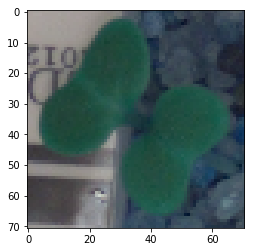

In [5]:
import matplotlib.pyplot as plt

plt.imshow(images[0])
plt.show()

Перемешаем выборку и преобразуем лейблы к one-hot encoding:

In [6]:
from sklearn.model_selection import train_test_split
from keras.utils import np_utils

X_train, X_test, y_train, y_test = train_test_split(images, labels, random_state=123)
Y_train = np_utils.to_categorical(y_train, num_classes)
Y_test  = np_utils.to_categorical(y_test, num_classes)

Using TensorFlow backend.


Построим нашу модель:

In [8]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D

model = Sequential()

model.add(Conv2D(10, kernel_size=(3, 3), activation='relu', input_shape=(imsize, imsize, 3)))
model.add(Conv2D(20, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(10, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(20, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

# model.add(Conv2D(10, kernel_size=(3, 3), activation='relu'))
# model.add(Conv2D(20, kernel_size=(3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

Обучим нашу модель:

In [9]:
batch_size = 8
epochs = 20

h = model.fit(X_train, Y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(X_test, Y_test))

W0708 02:04:31.706613 23988 deprecation.py:323] From D:\Programs\Anaconda\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 2490 samples, validate on 831 samples
Epoch 1/20
2490/2490 [==============================] - 31s 12ms/step - loss: 13.2473 - acc: 0.1763 - val_loss: 13.0729 - val_acc: 0.1889
Epoch 2/20
2490/2490 [==============================] - 25s 10ms/step - loss: 12.7765 - acc: 0.2036 - val_loss: 12.6462 - val_acc: 0.2154
Epoch 3/20
2490/2490 [==============================] - 25s 10ms/step - loss: 13.0158 - acc: 0.1892 - val_loss: 12.6462 - val_acc: 0.2154
Epoch 4/20
2490/2490 [==============================] - 25s 10ms/step - loss: 9.9420 - acc: 0.1859 - val_loss: 1.9236 - val_acc: 0.1793
Epoch 5/20
2490/2490 [==============================] - 25s 10ms/step - loss: 1.7022 - acc: 0.3406 - val_loss: 1.4727 - val_acc: 0.5054
Epoch 6/20
2490/2490 [==============================] - 25s 10ms/step - loss: 1.3343 - acc: 0.5064 - val_loss: 1.2219 - val_acc: 0.5776
Epoch 7/20
2490/2490 [==============================] - 25s 10ms/step - loss: 1.1185 - acc: 0.6012 - val_loss: 1.0253 - val_acc: 0.

Построим графики ошибки и точности:

Text(0, 0.5, 'Validation Accuracy')

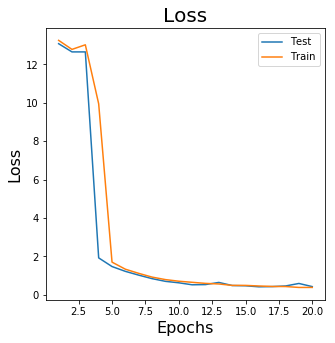

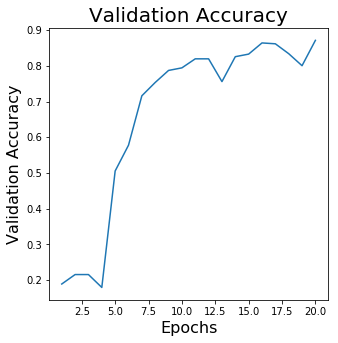

In [10]:
plt.figure(figsize=(5, 5))
plt.plot(range(1, epochs + 1), h.history['val_loss'], label='Test')
plt.plot(range(1, epochs + 1), h.history['loss'], label='Train')
plt.title('Loss', fontsize=20)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend()
plt.figure(figsize=(5, 5))
plt.plot(range(1, epochs + 1), h.history['val_acc'])
plt.title('Validation Accuracy', fontsize=20)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Validation Accuracy', fontsize=16)

Точность не всегда является объективны показателем, посомотрим на матрицу ошибок:

In [11]:
from sklearn.metrics import classification_report

labels_pred = [np.argmax(pred) for pred in model.predict(X_test)]
labels_fact = [np.argmax(fact) for fact in Y_test]

print(classification_report(labels_fact, labels_pred))

              precision    recall  f1-score   support

           0       0.96      0.84      0.90       103
           1       0.87      0.98      0.92       179
           2       0.83      0.81      0.82        72
           3       0.88      0.73      0.80        63
           4       0.81      0.86      0.83       157
           5       0.89      0.91      0.90       150
           6       0.91      0.80      0.85       107

   micro avg       0.87      0.87      0.87       831
   macro avg       0.88      0.85      0.86       831
weighted avg       0.87      0.87      0.87       831



Минимальный $precision$ - 0.83, а минимальный $recall$ - 0.73, неплохой результат. Сохраним эту модель на диск:

In [12]:
import h5py

model_json = model.to_json()
with open(path + '/' + "model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights(path + '/' + "model.h5")
print("Model has been saved to disk")

Model has been saved to disk
